In [1]:
"""It contains the necessary libraries for the project. As well as some more 
experimental libraries that may not be used in the final version of the project."""

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.ensemble import BalancedRandomForestClassifier
from scipy import stats
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     train_test_split ,cross_val_score,
                                     StratifiedKFold)
from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier, 
                              RandomForestClassifier, VotingClassifier)
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, f1_score )
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (FunctionTransformer, LabelEncoder, 
                                   MinMaxScaler, OneHotEncoder, 
                                   OrdinalEncoder, StandardScaler)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier

In [2]:
# Load the dataset
data = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv')
data.head()

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
0,2009-04-17,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other,no
1,2009-10-11,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,NaN,no
2,2010-11-20,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,NaN,no
3,2009-09-01,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,NaN,no
4,2008-01-29,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,NaN,no


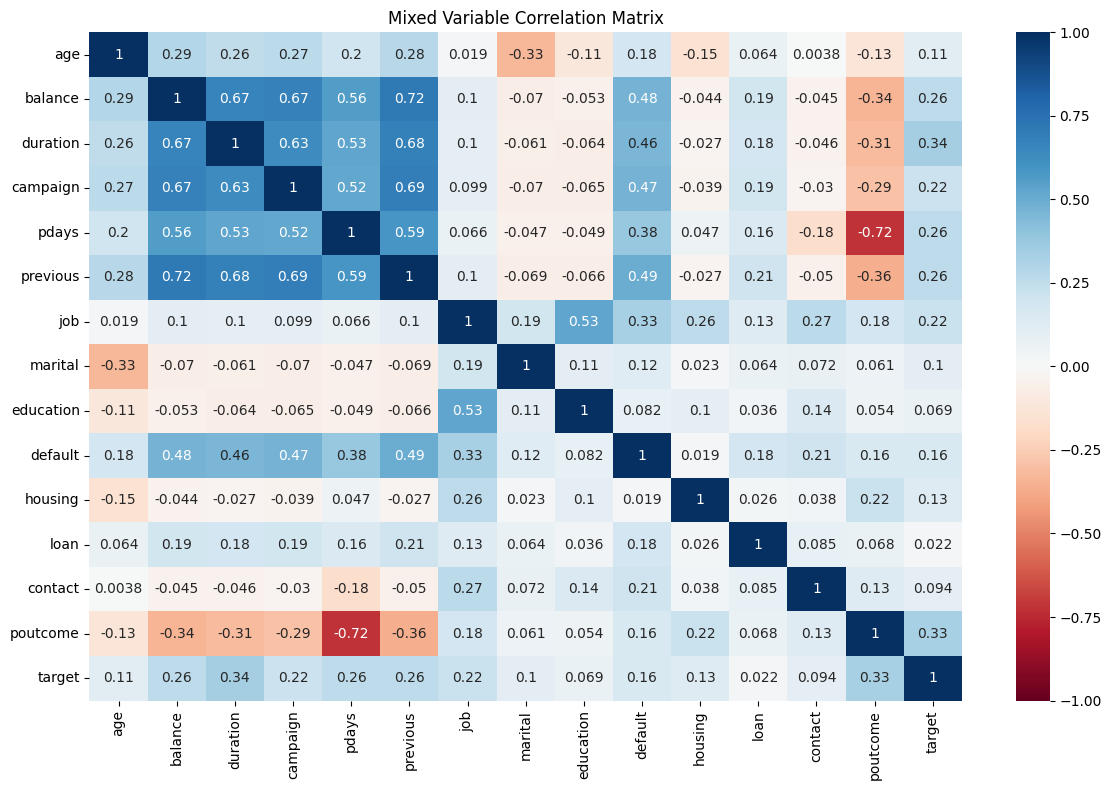

In [3]:
def mixed_correlation(df):
    """
    Calculate a correlation matrix for mixed data types (numerical and categorical) in a DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.

    Returns:
    pd.DataFrame: A correlation matrix with correlation coefficients between variables.
    """
    # 1. Identify column types
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns

    # 2. Initialize correlation matrix
    all_cols = pd.concat([df[numeric_cols], df[categorical_cols]], axis=1)
    corr_matrix = pd.DataFrame(index=all_cols.columns, columns=all_cols.columns)

    # 3. Calculate correlations
    for col1 in all_cols.columns:
        for col2 in all_cols.columns:
            if col1 in numeric_cols and col2 in numeric_cols:
                # Pearson correlation for numeric-numeric pairs
                corr_matrix.loc[col1, col2] = df[col1].corr(df[col2])
            elif col1 in categorical_cols and col2 in categorical_cols:
                # Cramér's V for categorical-categorical pairs
                confusion_matrix = pd.crosstab(df[col1], df[col2])
                chi2 = stats.chi2_contingency(confusion_matrix)[0]
                n = confusion_matrix.sum().sum()
                phi2 = chi2 / n
                r, k = confusion_matrix.shape
                corr_matrix.loc[col1, col2] = np.sqrt(phi2 / min(k - 1, r - 1))
            else:
                # Point-biserial correlation for numeric-categorical pairs
                cat_col = col1 if col1 in categorical_cols else col2
                num_col = col2 if col1 in categorical_cols else col1
                encoded = LabelEncoder().fit_transform(df[cat_col])
                corr_matrix.loc[col1, col2] = stats.pointbiserialr(encoded, df[num_col])[0]

    # 4. Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix.astype(float),
                annot=True,
                cmap='RdBu',
                center=0,
                vmin=-1,
                vmax=1)
    plt.title('Mixed Variable Correlation Matrix')
    plt.tight_layout()
    plt.show()

    return corr_matrix

# Usage
correlation_matrix = mixed_correlation(data.drop(columns='last contact date', axis=1))

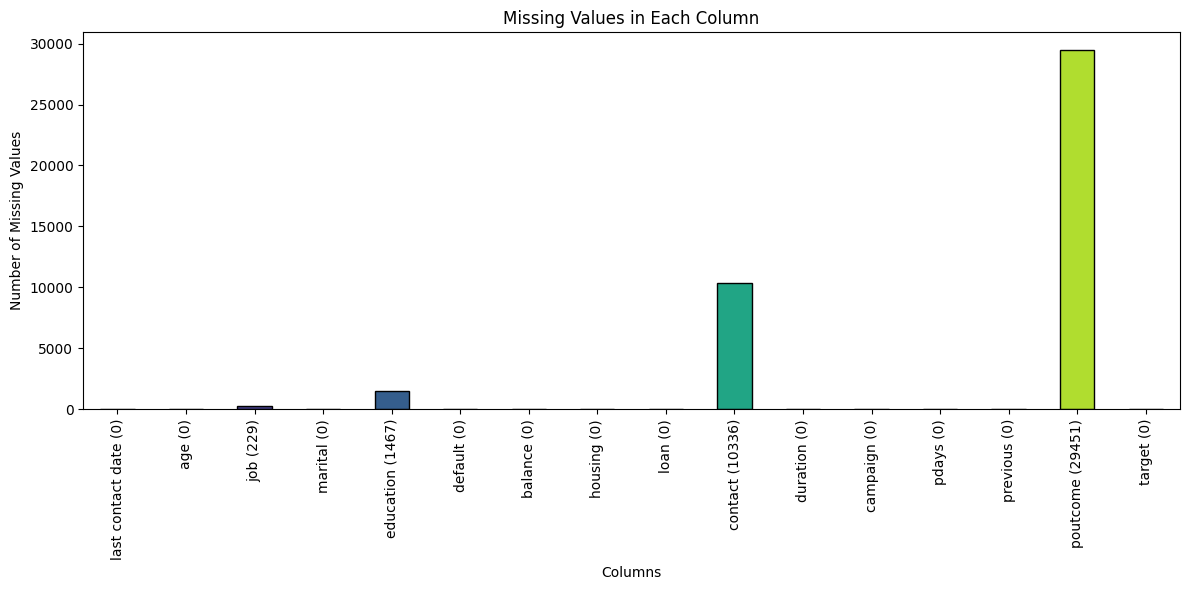

In [4]:
missing_values = data.isnull().sum()

# Update the index to include the number of missing values
missing_values.index = [f'{col} ({missing_values[col]})' for col in missing_values.index]

# Plot bar chart of missing values
plt.figure(figsize=(12, 6))
missing_values.plot(kind='bar', color=sns.color_palette("viridis", len(missing_values)), edgecolor='black')
plt.title('Missing Values in Each Column')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.tight_layout()
plt.show()

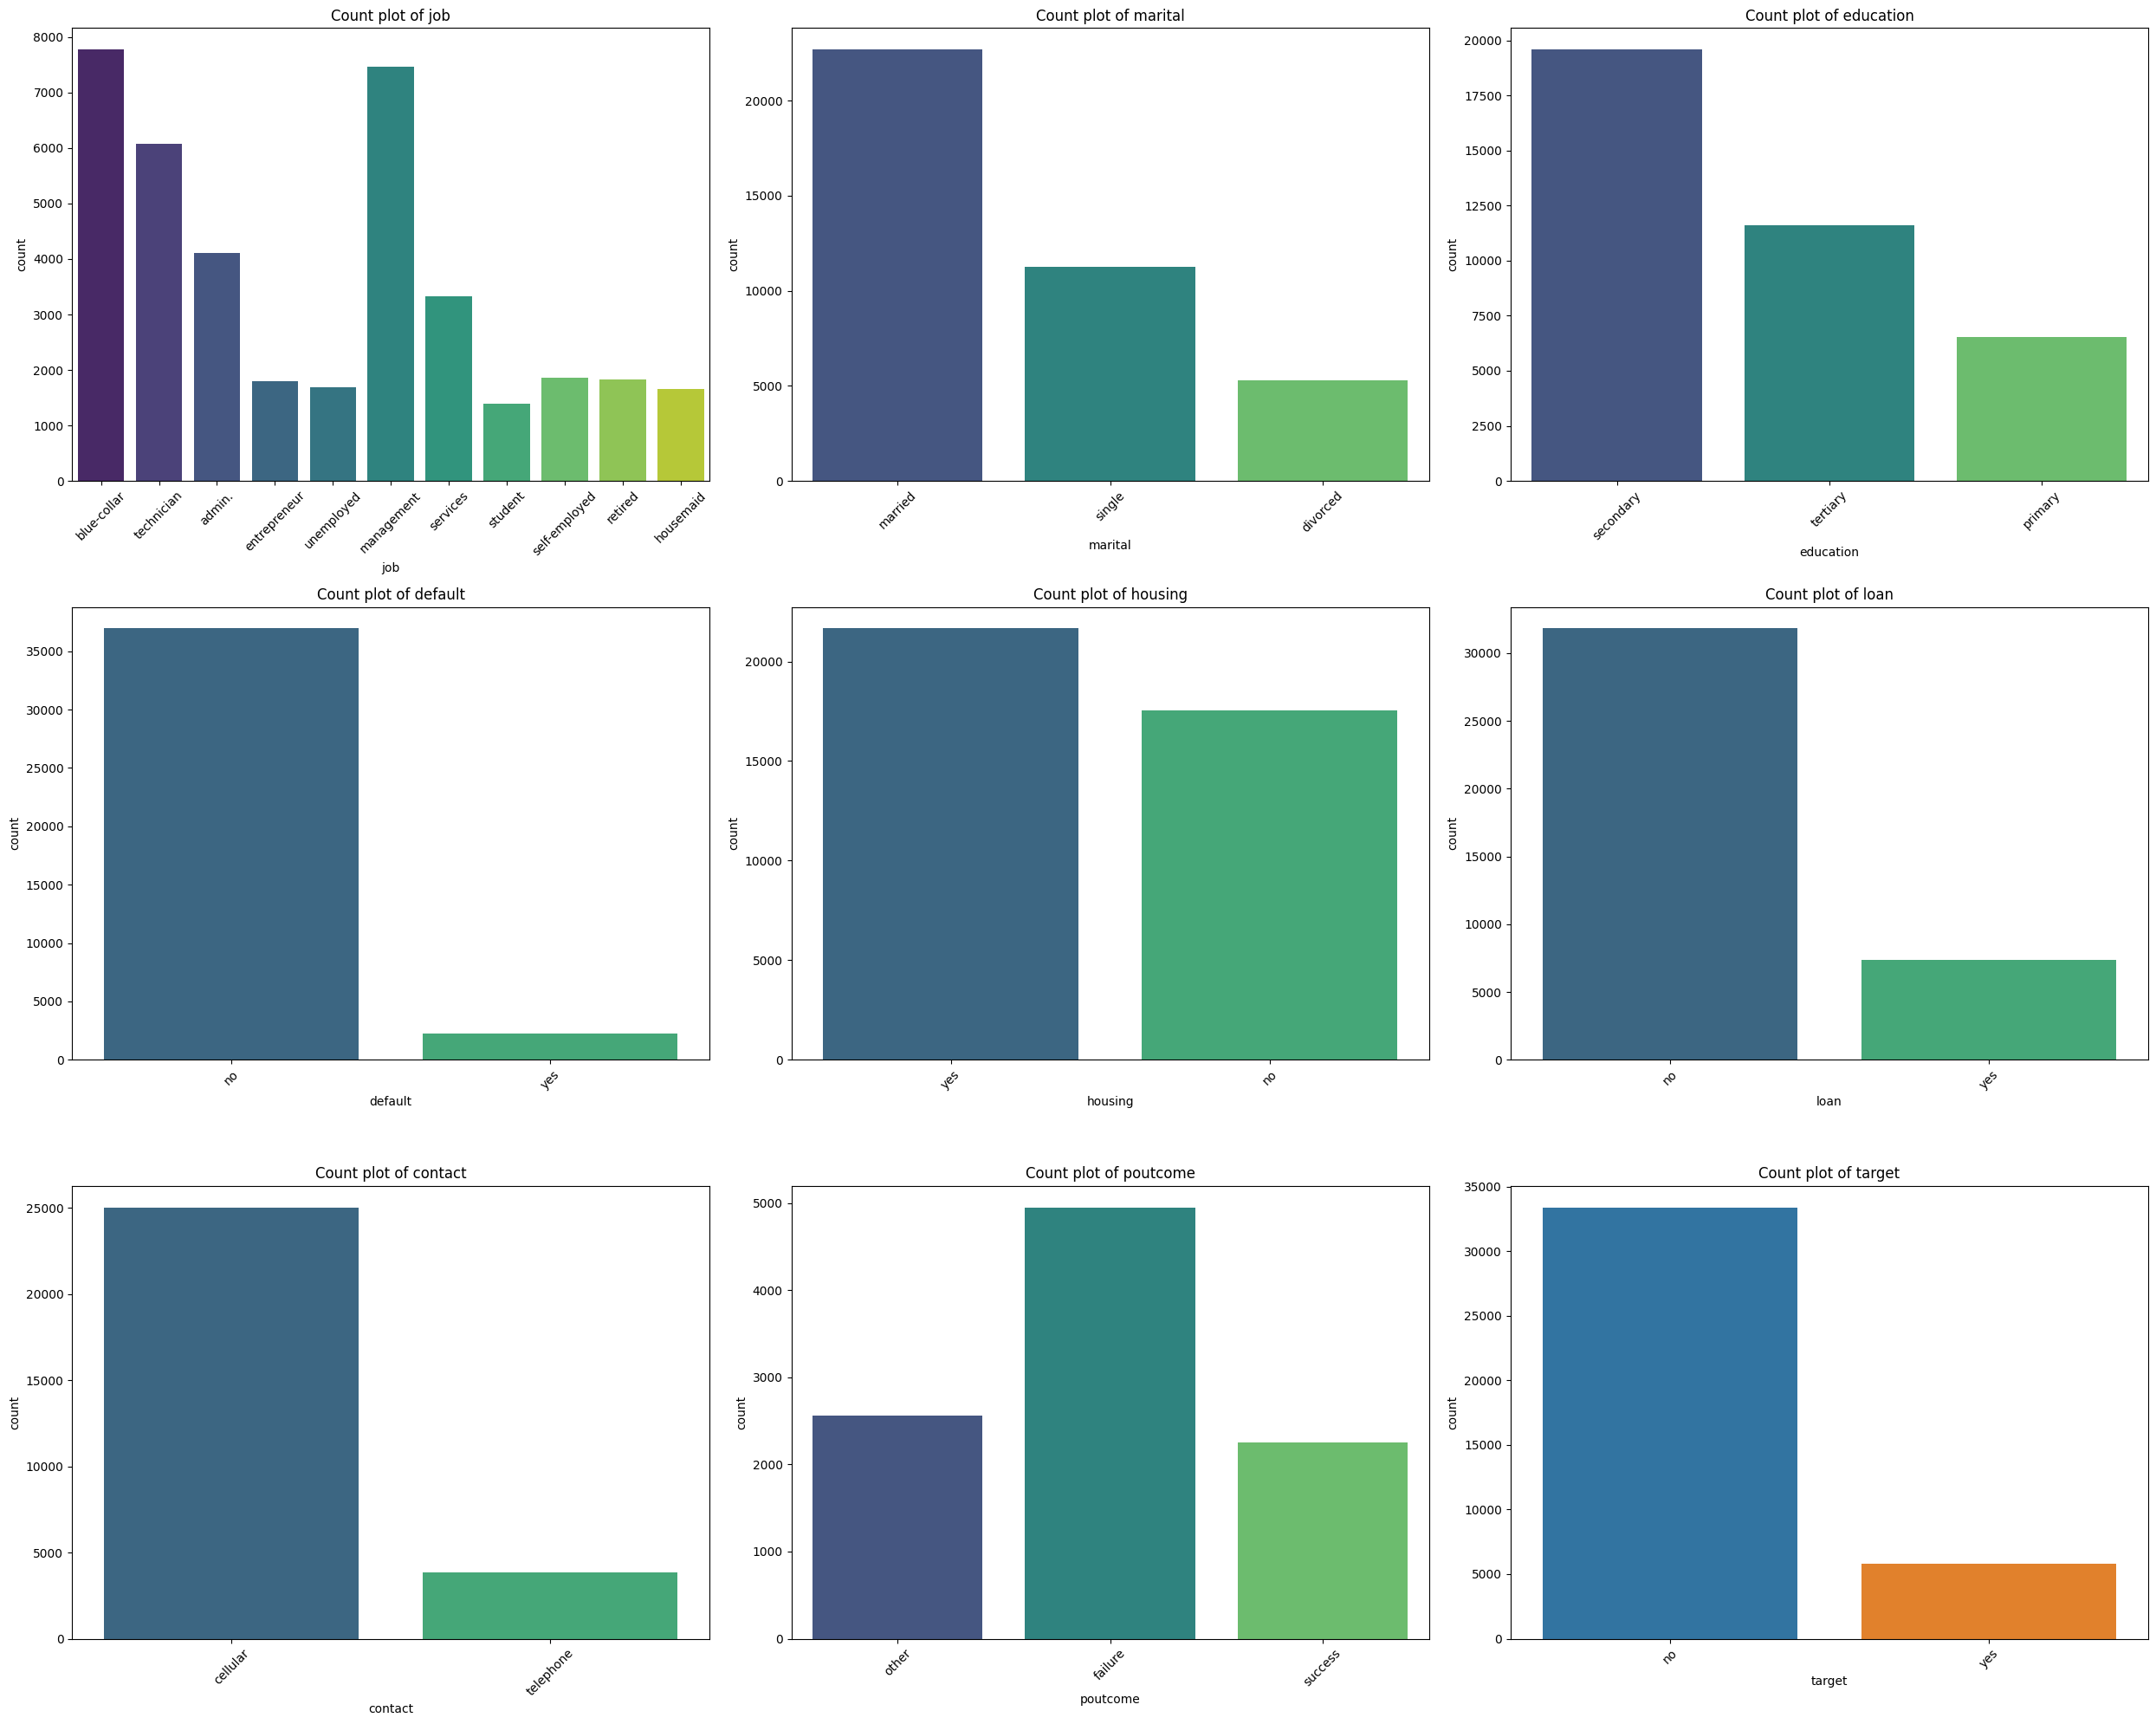

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# List of categorical columns excluding 'last contact date'
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
categorical_columns.remove('last contact date')

# Plot count plots for each categorical column
plt.figure(figsize=(25, 20))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(3, 3, i)
    sns.countplot(data=data, x=col, palette='viridis')
    plt.title(f'Count plot of {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
# Assign the x variable to hue and set legend=False
sns.countplot(data=data, x=col)
plt.show()

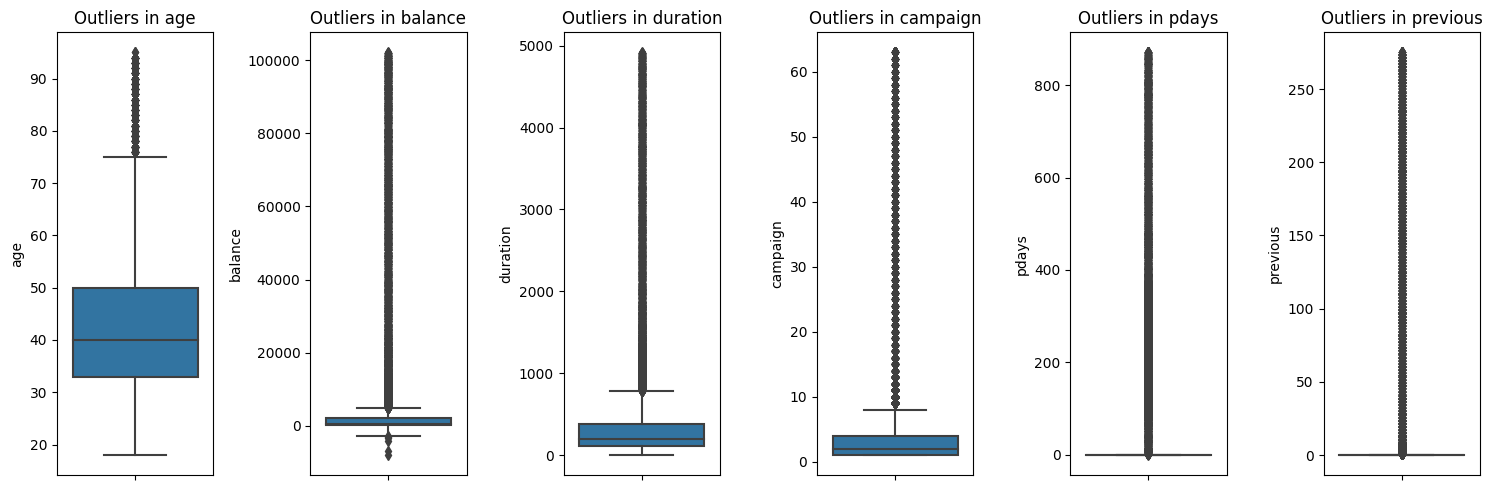

Original shape: (39211, 16)
Shape after removing outliers: (25017, 16)


In [6]:
def detect_outliers(df, numeric_cols, method='iqr'):
    """
    Detect outliers using multiple methods
    """
    outlier_indices = set()
    
    if method == 'iqr':
        for col in numeric_cols:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            outliers = df[(df[col] < lower) | (df[col] > upper)].index
            outlier_indices.update(outliers)
            
    elif method == 'zscore':
        for col in numeric_cols:
            z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
            outliers = df[z_scores > 3].index
            outlier_indices.update(outliers)
    
    return list(outlier_indices)

def plot_outliers(df, numeric_cols):
    """
    Plot boxplots to visualize outliers
    """
    plt.figure(figsize=(15, 5))
    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(1, len(numeric_cols), i)
        sns.boxplot(y=df[col])
        plt.title(f'Outliers in {col}')
    plt.tight_layout()
    plt.show()

# Usage
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns

# Plot outliers
plot_outliers(data, numeric_cols)

# Detect outliers using different methods
iqr_outliers = detect_outliers(data, numeric_cols, method='iqr')
zscore_outliers = detect_outliers(data, numeric_cols, method='zscore')

# Remove outliers (using IQR method as example)
df_clean = data.drop(iqr_outliers)

print(f"Original shape: {data.shape}")
print(f"Shape after removing outliers: {df_clean.shape}")

Education NaNs: 1467
Job NaNs: 229


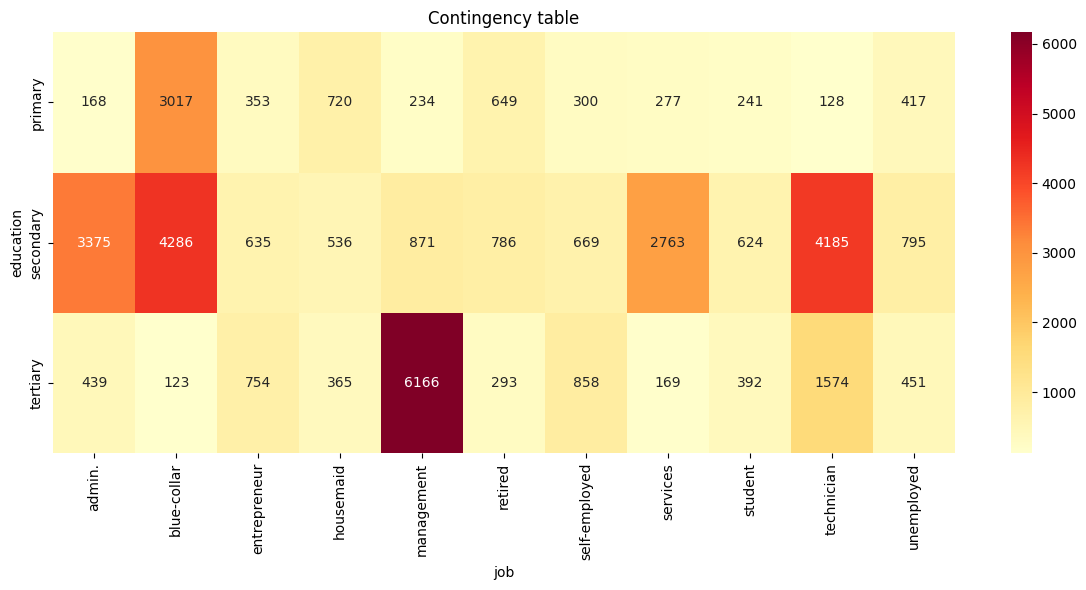

In [7]:
print(f"Education NaNs: {data['education'].isna().sum()}")
print(f"Job NaNs: {data['job'].isna().sum()}")

# 2. Create contingency table (excluding NaNs)
contingency = pd.crosstab(
    data['education'], 
    data['job'],
    #margins=True
)

plt.figure(figsize=(12, 6))
plt.title("Contingency table")
sns.heatmap(contingency , annot=True , fmt = 'd' , cmap='YlOrRd')
plt.tight_layout()
plt.show()

Accuracy: 0.6712147304278713


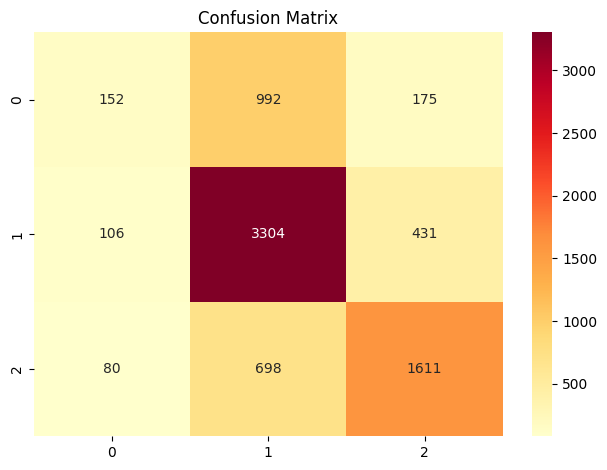

In [8]:
import warnings

warnings.filterwarnings('ignore')

def job_imputer(df):
    """
    Impute missing values in 'job' and 'education' columns of the dataframe.

    This function performs the following imputations:
    1. For the 'job' column:
       - If 'job' is missing and 'education' is 'primary', impute with 'blue-collar'.
       - If 'job' is missing and 'education' is 'secondary', impute with a random choice between 'blue-collar' and 'technician'.
       - If 'job' is missing and 'education' is 'tertiary', impute with 'management'.
       - If both 'job' and 'education' are missing, impute 'job' with 'blue-collar'.
   """
    

    #create a copy of the dataframe
    job_edu = df[['job', 'education']].copy()

    # Impute missing values in job column
    job_edu['job'] = job_edu.apply(
        lambda row: 'blue-collar' if pd.isna(row['job']) and row['education'] == 'primary' else
                    np.random.choice(['blue-collar', 'technician' , 'admin.' , 'services']) if pd.isna(row['job']) and row['education'] == 'secondary' else
                    'management' if pd.isna(row['job']) and row['education'] == 'tertiary' else
                    'blue-collar' if pd.isna(row['job']) and pd.isna(row['education']) else row['job'],
        axis=1
    )

    return job_edu


edu_encode = OneHotEncoder(drop='first' , sparse_output=False)
edu_label = LabelEncoder()

job_edu = job_imputer(data)

X , y = job_edu.dropna().drop('education', axis=1) , job_edu.dropna()['education']
X = edu_encode.fit_transform(X)
y = edu_label.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


rf_edu = RandomForestClassifier(random_state=42)
rf_edu.fit(X_train, y_train)
y_pred = rf_edu.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='YlOrRd')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

Accuracy: 0.5251024590163934


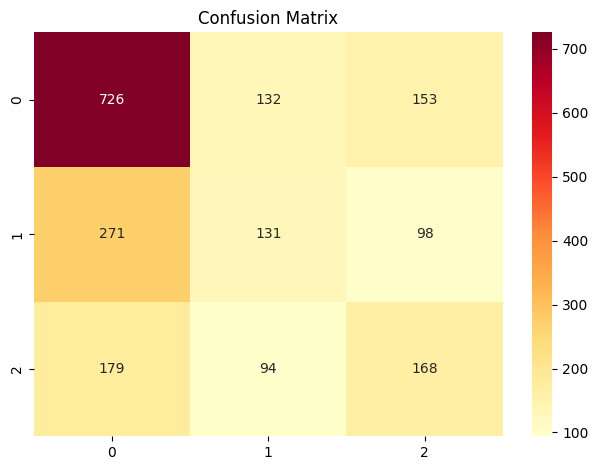

In [9]:
index_for_poutcome_df = correlation_matrix[correlation_matrix['poutcome'].abs() > 0.3]['poutcome'].drop(['target']).index
poutcome_df = data[index_for_poutcome_df]

poutcome_df.dropna(inplace=True)
X , y = poutcome_df.drop('poutcome', axis=1) , poutcome_df['poutcome']

std_poutcome = StandardScaler()
mm_poutcome = MinMaxScaler()
encoder_poutcome = OneHotEncoder(drop='first', sparse=False)
label_poutcome = LabelEncoder()

col_trans_poutcome = ColumnTransformer([
    ('std', std_poutcome, [ 'pdays' , 'balance' , 'previous' , 'duration' ])
])

y = label_poutcome.fit_transform(y)

X_train , X_test , y_train , y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = col_trans_poutcome.fit_transform(X_train)
X_test = col_trans_poutcome.transform(X_test)

rf_poutcome = RandomForestClassifier(n_estimators=200,random_state=42)
rf_poutcome.fit(X_train, y_train)
y_pred = rf_poutcome.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='YlOrRd')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


In [10]:
def job_edu_imputer(df):

    job_edu = job_imputer(df[['job', 'education']].copy())

    job_edu.loc[job_edu['education'].isna(), 'education'] = job_edu[job_edu['education'].isna()].apply(
    lambda row: edu_label.inverse_transform(rf_edu.predict(edu_encode.transform([[row['job']]])))[0],
    axis=1
    )

    df['job'] = job_edu['job']
    df['education'] = job_edu['education']

    return df


def poutcome_imputer(df):   
    """
    Imputes missing values in the 'poutcome' column of the given DataFrame.

    This function uses a pre-trained Random Forest model to predict and fill 
    missing values in the 'poutcome' column based on the values of 'pdays', 
    'balance', 'previous', and 'duration' columns.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the columns 
                           'pdays', 'balance', 'previous', 'duration', and 'poutcome'.

    Returns:
    pandas.DataFrame: The DataFrame with missing 'poutcome' values imputed.
    """
    poutcome_test = df[['pdays' , 'balance' , 'previous' , 'duration' , 'poutcome' ]]

    poutcome_nan = poutcome_test[poutcome_test['poutcome'].isna()]
    X = col_trans_poutcome.transform(poutcome_nan.drop('poutcome', axis=1))
    values = label_poutcome.inverse_transform(rf_poutcome.predict(X))
    poutcome_nan['poutcome'] = values
    poutcome_test_combined = poutcome_test.combine_first(poutcome_nan)

    df['poutcome'] = poutcome_test_combined['poutcome']

    return df

def date_feature(df):
    """
    Extracts features from the 'last contact date' column of the given DataFrame.

    This function extracts the following features from the 'last contact date' column:
    - 'day_of_week': The day of the week when the last contact was made.
    - 'month': The month when the last contact was made.
    - 'quarter': The quarter of the year when the last contact was made.
    - 'is_weekend': A binary flag indicating whether the last contact was made on a weekend.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the 'last contact date' column.

    Returns:
    pandas.DataFrame: The DataFrame with additional date features.
    """
    date = pd.to_datetime(df['last contact date'])
    df['day_of_week'] = date.dt.day_name()
    df['month'] = date.dt.month_name()
    df['is_weekend'] = date.dt.dayofweek.isin([5, 6]).astype(int)
    df.drop('last contact date', axis=1, inplace=True)

    return df

def first_imputer(df):
    """Imputes missing values in the given DataFrame by applying specific imputation functions.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the data to be imputed.

    Returns:
    pandas.DataFrame: The DataFrame with imputed values.
    """
    
    df = job_edu_imputer(df)
    df = poutcome_imputer(df)
    df = date_feature(df)

    return df



In [11]:
# Step 1: Define the imputers and transformers
"""
This script defines various preprocessing pipelines and a column transformer for a machine learning project.

Steps:
1. Define the imputers and transformers:
    - `mode_imputer`: Pipeline to impute missing values with the most frequent value and then apply one-hot encoding.
    - `ordinal_mode_imputer`: Pipeline to impute missing values with the most frequent value and then apply ordinal encoding.
    - `other_imputer`: Pipeline to impute missing values with a constant value 'other' and then apply one-hot encoding.
    - `category_encoder`: One-hot encoder to handle categorical variables, ignoring unknown categories.
    - `mm_scaler`: Min-max scaler to scale numerical features to a given range.

2. Create the ColumnTransformer:
    - `column_transform`: A ColumnTransformer that applies the defined pipelines to specific columns:
        - `mode_imputer`: Applies to 'job' and 'contact' columns.
        - `ordinal_mode_imputer`: Applies to 'education' column.
        - `poutcome_imputer`: Applies to 'poutcome' column.
        - `dropper`: Drops the 'last contact date' column.
        - `encoder`: Applies one-hot encoding to 'marital', 'default', 'housing', and 'loan' columns.
        - `mm_scaler`: Applies min-max scaling to 'age', 'balance', 'duration', 'campaign', 'pdays', and 'previous' columns.
    - `remainder='passthrough'`: Passes through other columns unchanged.
"""

mode_imputer = Pipeline(steps=[
    ('mode' , SimpleImputer(strategy='most_frequent')),
    ('encode' , OneHotEncoder(drop='first'))])

ordinal = Pipeline(steps=[
    ('ordinal' , OrdinalEncoder(categories=[['primary', 'secondary', 'tertiary']]))
])

other_imputer = Pipeline(steps=[
    ('mean' , SimpleImputer(strategy='constant', fill_value='other')),
    ('encode' , OneHotEncoder(drop='first'))])


category_encoder = OneHotEncoder(drop='first',sparse_output=False)


mm_scaler = MinMaxScaler()

# Step 2: Create the ColumnTransformer
column_transform = ColumnTransformer(
    transformers=[
        # Impute and then encode categorical columns
        ('mode_imputer', mode_imputer, ['contact']),
        ('ordinal', ordinal , ['education']),
        # Apply one-hot encoding on the imputed categorical columns
        ('encoder', category_encoder, ['marital' ,'default', 'housing', 'loan' ,'job' ,'poutcome' , 'month' , 'day_of_week' , 'is_weekend']),
        ('mm_scaler' , mm_scaler , ['age' , 'balance' , 'duration' , 'campaign' , 'pdays' , 'previous'])
    ],
    remainder='passthrough'  # Pass through other columns unchanged
)

In [12]:
# Train test split
"""
This script performs the following steps:
1. Splits the dataset into features (X) and target (y).
2. Converts the target variable to binary values (1 for 'yes' and 0 for 'no').
3. Splits the data into training and testing sets with stratification to maintain the target variable distribution.
4. Applies column transformations to the training and testing feature sets.

Variables:
    X (DataFrame): Features of the dataset after dropping the target column.
    y (Series): Binary target variable.
    X_train (DataFrame): Training set features after transformation.
    X_test (DataFrame): Testing set features after transformation.
    y_train (Series): Training set target variable.
    y_test (Series): Testing set target variable.

Functions:
    train_test_split: Splits the dataset into training and testing sets.
    column_transform.fit_transform: Fits the column transformer to the training data and transforms it.
    column_transform.transform: Transforms the testing data using the fitted column transformer.
"""
data = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv')
data = first_imputer(data)
X , y = data.drop('target' , axis=1) , data['target'].apply(lambda x: 1 if x == 'yes' else 0)
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.1 ,stratify=y ,random_state=0)

X_train = column_transform.fit_transform(X_train)
X_test = column_transform.transform(X_test)

In [13]:
X_train.shape , X_test.shape , y_train.shape , y_test.shape

((35289, 43), (3922, 43), (35289,), (3922,))

In [14]:
from imblearn.over_sampling import ADASYN, SMOTE , RandomOverSampler ,  BorderlineSMOTE

majority_count = y_train.value_counts().max()
desired_majority_count = int(majority_count * 1.0)
desired_minority_count = int(majority_count * 0.9)

smote = SMOTE(sampling_strategy={0:desired_majority_count , 1:desired_minority_count} ,random_state=42 , n_jobs=-1)
adasyn = ADASYN(sampling_strategy={0 : desired_majority_count , 1 : desired_minority_count}, random_state=42, n_jobs=-1)
borderline_smote = BorderlineSMOTE(sampling_strategy='auto', random_state=42, n_jobs=-1)
random_oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)





X_resampled, y_resampled = borderline_smote.fit_resample(X_train, y_train)



print('X_resampled_enn shape: ', X_resampled.shape , '\n' ,
       'y_resampled_enn shape: ', y_resampled.shape)

y_resampled.value_counts()

X_resampled_enn shape:  (60090, 43) 
 y_resampled_enn shape:  (60090,)


target
0    30045
1    30045
Name: count, dtype: int64

In [15]:
from imblearn.under_sampling import EditedNearestNeighbours, NearMiss

enn = EditedNearestNeighbours(sampling_strategy='majority', n_neighbors=3, kind_sel='all', n_jobs=-1)

nm = NearMiss(sampling_strategy='majority', version=2, n_neighbors=3, n_jobs=-1)

X_resampled, y_resampled = enn.fit_resample(X_resampled, y_resampled)

print('X_resampled_enn shape: ', X_resampled.shape , '\n' ,
       'y_resampled_enn shape: ', y_resampled.shape)

y_resampled.value_counts()

X_resampled_enn shape:  (52006, 43) 
 y_resampled_enn shape:  (52006,)


target
1    30045
0    21961
Name: count, dtype: int64

F1 Score with Random Forest: 0.7164094820022782
Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.97      0.79      0.87      3339
           1       0.42      0.85      0.56       583

    accuracy                           0.80      3922
   macro avg       0.69      0.82      0.72      3922
weighted avg       0.89      0.80      0.83      3922



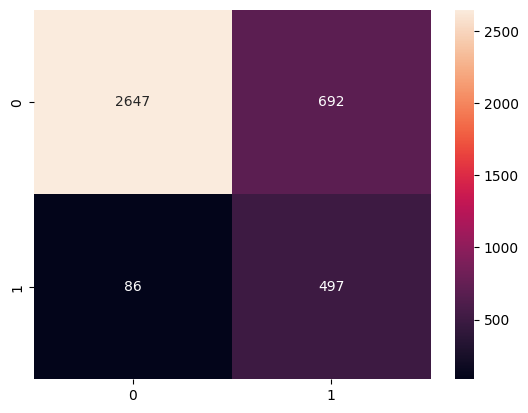

In [16]:
# -------- Random Forest Classifier --------
# Train a Random Forest model

rf_model = RandomForestClassifier(class_weight={0: 1, 1: 1} , n_estimators=1000 , n_jobs=-1 , criterion='gini' , max_features='auto' , max_depth=9)
rf_model.fit(X_resampled, y_resampled)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Calculate F1 score and classification report for Random Forest
f1_rf = f1_score(y_test, y_pred_rf, average='macro')
report_rf = classification_report(y_test, y_pred_rf)

print(f"F1 Score with Random Forest: {f1_rf}")
print("Classification Report for Random Forest:\n", report_rf)
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d')
plt.show()



f1_score of logistic:  0.7310332521482532
classification_report of logistic: 
               precision    recall  f1-score   support

           0       0.94      0.87      0.90      3339
           1       0.48      0.67      0.56       583

    accuracy                           0.84      3922
   macro avg       0.71      0.77      0.73      3922
weighted avg       0.87      0.84      0.85      3922



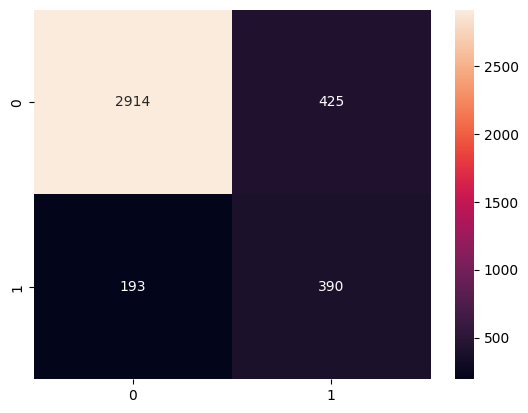

In [17]:
log_reg = LogisticRegression(C = 100 , class_weight = {0 : 4 , 1 : 1} , fit_intercept = True , max_iter = 100 , n_jobs = -1 , random_state = 42 , penalty='l2',warm_start=True)

log_reg.fit(X_resampled , y_resampled)

y_pred_log = log_reg.predict(X_test)
report_log = classification_report(y_test , y_pred_log)
f1_log = f1_score(y_test , y_pred_log , average='macro')
print('f1_score of logistic: ' , f1_log)
print('classification_report of logistic: \n' , report_log)
sns.heatmap(confusion_matrix(y_test , y_pred_log) , annot=True , fmt = 'd')
plt.show()

f1 score for xgb:  0.7464653376249011
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      3339
           1       0.52      0.65      0.58       583

    accuracy                           0.86      3922
   macro avg       0.73      0.77      0.75      3922
weighted avg       0.87      0.86      0.87      3922



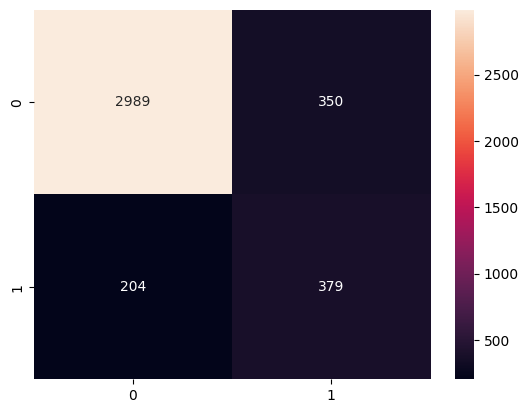

In [18]:
xgb = XGBClassifier(n_estimators=1000,
                    learning_rate=1,
                    max_depth=1,
                    random_state=42,
                    n_jobs=-1,
                    verbosity=0,
                    objective='binary:logistic',
                    scale_pos_weight=0.5,
                    use_label_encoder=False
                    )
xgb.fit(X_resampled , y_resampled)

print('f1 score for xgb: ' , f1_score(y_test , xgb.predict(X_test) , average='macro'))
print(classification_report(y_test , xgb.predict(X_test)))
sns.heatmap(confusion_matrix(y_test , xgb.predict(X_test)) , annot = True , fmt = 'd')
plt.show()

In [19]:
abc = AdaBoostClassifier(n_estimators=1000 , learning_rate=0.1 , random_state=42)
abc.fit(X_resampled, y_resampled)

print(classification_report(y_test , abc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.82      0.89      3339
           1       0.44      0.80      0.57       583

    accuracy                           0.82      3922
   macro avg       0.70      0.81      0.73      3922
weighted avg       0.88      0.82      0.84      3922



f1 score for voting classifier:  0.7445458165306604
              precision    recall  f1-score   support

           0       0.95      0.87      0.91      3339
           1       0.49      0.72      0.58       583

    accuracy                           0.85      3922
   macro avg       0.72      0.79      0.74      3922
weighted avg       0.88      0.85      0.86      3922



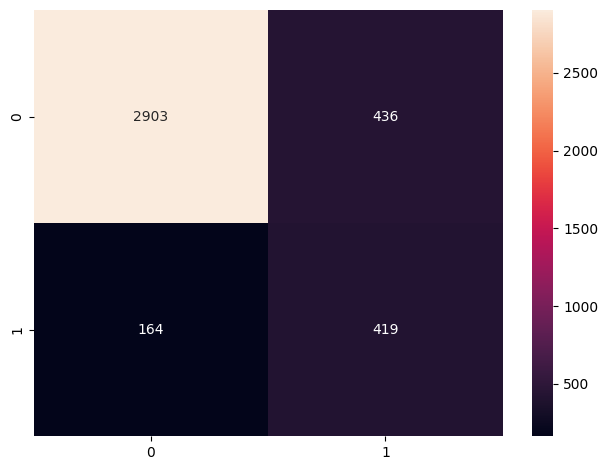

In [20]:
voting_clf = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('xgb' , xgb),
    ('ada' , abc),
    ('log_reg' , log_reg)
], voting='soft') 

voting_clf.fit(X_resampled , y_resampled)
voting_clf.predict(X_test)
print('f1 score for voting classifier: ' , f1_score(y_test , voting_clf.predict(X_test) , average='macro'))
print(classification_report(y_test , voting_clf.predict(X_test)))

sns.heatmap(confusion_matrix(y_test , voting_clf.predict(X_test)) , annot=True , fmt='d')
plt.tight_layout()
plt.show()

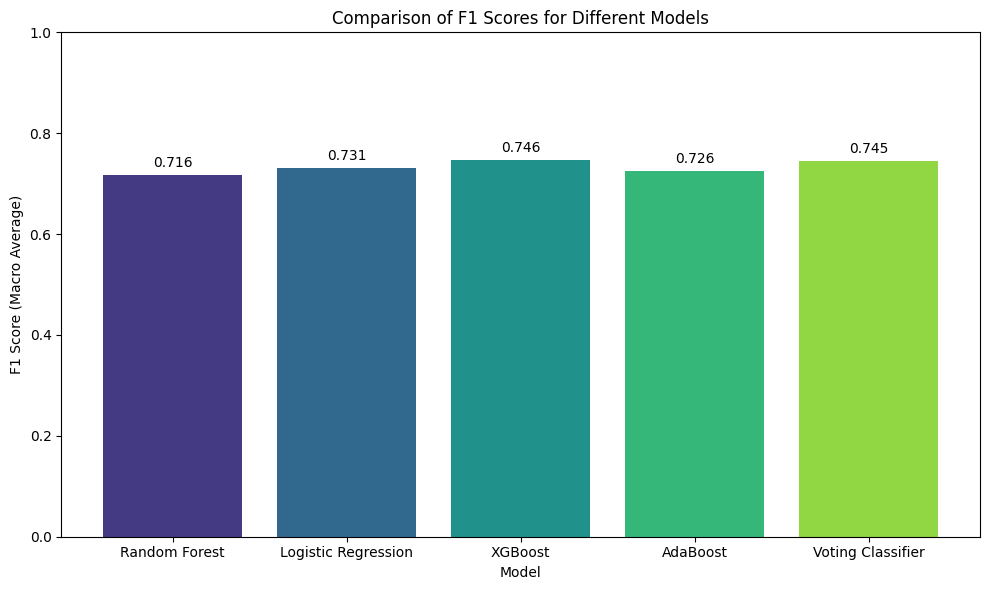

In [21]:
# F1 scores for each model
f1_scores = {
    'Random Forest': f1_rf,
    'Logistic Regression': f1_log,
    'XGBoost': f1_score(y_test, xgb.predict(X_test), average='macro'),
    'AdaBoost': f1_score(y_test, abc.predict(X_test), average='macro'),
    'Voting Classifier': f1_score(y_test, voting_clf.predict(X_test), average='macro')
}

# Plotting the F1 scores
plt.figure(figsize=(10, 6))
bars = plt.bar(f1_scores.keys(), f1_scores.values(), color=sns.color_palette("viridis", len(f1_scores)))
plt.xlabel('Model')
plt.ylabel('F1 Score (Macro Average)')
plt.title('Comparison of F1 Scores for Different Models')
plt.ylim(0, 1)

# Adding the F1 score values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3), ha='center', va='bottom')

plt.tight_layout()
plt.show()

Iteration 1, loss = 0.36603036
Validation score: 0.875024
Iteration 2, loss = 0.21562983
Validation score: 0.923284
Iteration 3, loss = 0.18178743
Validation score: 0.929629
Iteration 4, loss = 0.17179571
Validation score: 0.928668
Iteration 5, loss = 0.15607773
Validation score: 0.940973
Iteration 6, loss = 0.14713481
Validation score: 0.943472
Iteration 7, loss = 0.13720181
Validation score: 0.937704
Iteration 8, loss = 0.13275085
Validation score: 0.944434
Iteration 9, loss = 0.12329711
Validation score: 0.947510
Iteration 10, loss = 0.11909907
Validation score: 0.941550
F1 Score with MLP: 0.7082927765566144
Classification Report for MLP:
               precision    recall  f1-score   support

           0       0.97      0.79      0.87      3339
           1       0.41      0.84      0.55       583

    accuracy                           0.79      3922
   macro avg       0.69      0.81      0.71      3922
weighted avg       0.88      0.79      0.82      3922



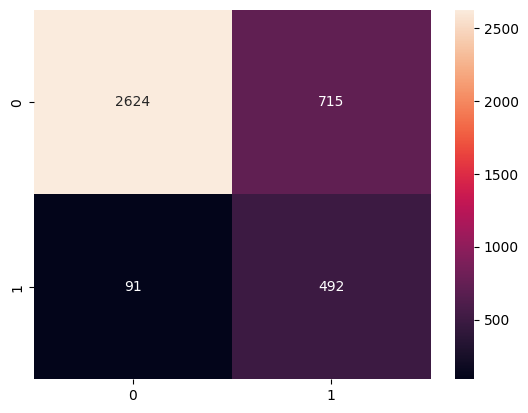

In [22]:
# Create and train neural network
mlp = MLPClassifier(
    hidden_layer_sizes=(100 , 100 ,100),  
    activation='relu',
    solver='adam',
    max_iter=10,
    random_state=42,
    learning_rate='adaptive',
    early_stopping=True,
    warm_start = True,
    verbose = True
)

mlp.fit(X_resampled, y_resampled)

# Make predictions
y_pred_mlp = mlp.predict(X_test)

# Calculate F1 score and classification report for MLP
f1_mlp = f1_score(y_test, y_pred_mlp, average='macro')
report_mlp = classification_report(y_test, y_pred_mlp)

print(f"F1 Score with MLP: {f1_mlp}")
print("Classification Report for MLP:\n", report_mlp)
sns.heatmap(confusion_matrix(y_test, y_pred_mlp), annot=True, fmt='d')
plt.show()


F1 Score with Perceptron: 0.6608079045311133
Classification Report for Perceptron:
               precision    recall  f1-score   support

           0       0.98      0.71      0.82      3339
           1       0.35      0.90      0.50       583

    accuracy                           0.73      3922
   macro avg       0.66      0.80      0.66      3922
weighted avg       0.88      0.73      0.77      3922



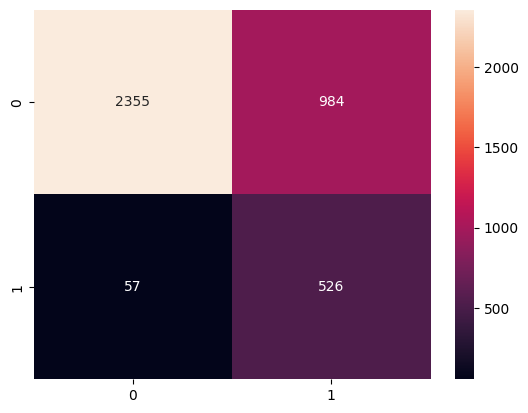

In [23]:
from sklearn.linear_model import Perceptron

# Initialize the Perceptron model
perceptron = Perceptron(max_iter=10, tol=1e-9, random_state=42, penalty='l1', alpha=0.001, eta0=1.0, early_stopping=False, validation_fraction=0.3)

# Train the Perceptron model
perceptron.fit(X_resampled, y_resampled)

# Make predictions
y_pred_perceptron = perceptron.predict(X_test)

# Calculate F1 score and classification report for Perceptron
f1_perceptron = f1_score(y_test, y_pred_perceptron, average='macro')
report_perceptron = classification_report(y_test, y_pred_perceptron)

print(f"F1 Score with Perceptron: {f1_perceptron}")
print("Classification Report for Perceptron:\n", report_perceptron)
sns.heatmap(confusion_matrix(y_test, y_pred_perceptron), annot=True, fmt='d')
plt.show()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 30045, number of negative: 21961
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10965
[LightGBM] [Info] Number of data points in the train set: 52006, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.577722 -> initscore=0.313428
[LightGBM] [Info] Start training from score 0.313428
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

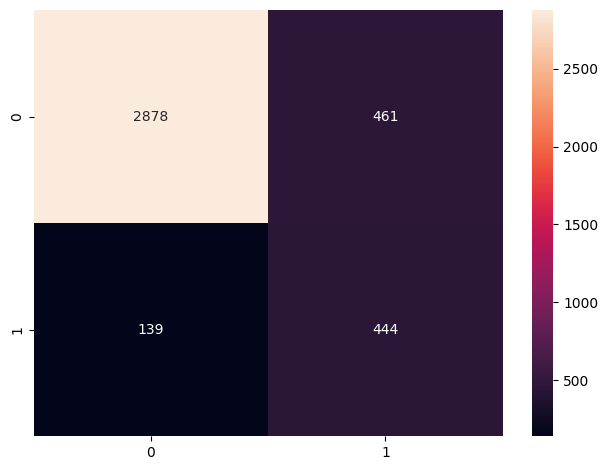

In [24]:
import lightgbm as lgb

lgbm = lgb.LGBMClassifier(n_estimators=1000,
                          learning_rate=0.1,
                          max_depth=5,
                          random_state=42,
                          n_jobs=-1,
                          boosting_type='gbdt',
                          objective='binary',
                          metric='binary_logloss'
                          )

lgbm.fit(X_resampled, y_resampled)

# Make predictions
y_pred_lgbm = lgbm.predict(X_test)

# Calculate F1 score and classification report for LightGBM
f1_lgbm = f1_score(y_test, y_pred_lgbm, average='macro')
report_lgbm = classification_report(y_test, y_pred_lgbm)

print(f"F1 Score with LightGBM: {f1_lgbm}")
print("Classification Report for LightGBM:\n", report_lgbm)

sns.heatmap(confusion_matrix(y_test, y_pred_lgbm), annot=True, fmt='d')
plt.tight_layout()
plt.show()


F1 Score with CatBoost: 0.7513157060427367
Classification Report for CatBoost:
               precision    recall  f1-score   support

           0       0.96      0.86      0.90      3339
           1       0.49      0.77      0.60       583

    accuracy                           0.85      3922
   macro avg       0.72      0.81      0.75      3922
weighted avg       0.89      0.85      0.86      3922



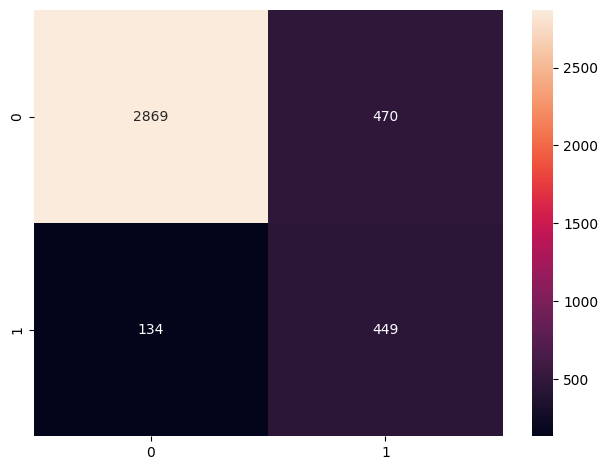

In [25]:
import catboost as cb

# Initialize the CatBoost model
catboost = cb.CatBoostClassifier(n_estimators=750,
                                 #iterations = 750,
                                 class_weights={0: 3, 1: 3},
                                 learning_rate=0.1,
                                 depth=3,
                                 loss_function='Logloss',
                                 random_state=42,
                                 verbose=0)

# Train the CatBoost model
catboost.fit(X_resampled, y_resampled)

# Make predictions
y_pred_catboost = catboost.predict(X_test)

# Calculate F1 score and classification report for CatBoost
f1_catboost = f1_score(y_test, y_pred_catboost, average='macro')
report_catboost = classification_report(y_test, y_pred_catboost)

print(f"F1 Score with CatBoost: {f1_catboost}")
print("Classification Report for CatBoost:\n", report_catboost)
sns.heatmap(confusion_matrix(y_test, y_pred_catboost), annot=True, fmt='d')
plt.tight_layout()
plt.show()



In [26]:
#full data training
def full_data_train(df):
    data = df.copy()
    data = first_imputer(data)
    data , target = data.drop('target' , axis=1) , data['target'].apply(lambda x: 1 if x == 'yes' else 0)
    data = column_transform.transform(data)
    
    data , target = borderline_smote.fit_resample(data , target)
    data , target = enn.fit_resample(data , target)
    
    return X_train , y_train
    

In [27]:
data = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv')
data , target = full_data_train(data)

In [29]:
#Loading Test DATA
test_df = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv')

#Applying same preprocesses as the train DATA
test_df = first_imputer(test_df)
test_x = column_transform.transform(test_df)
#test_x = scaler.transform(test_x)
test_pred = catboost.predict(test_x)

#saving the submission File
submission = pd.DataFrame({'id' :range(10000) , 'target' : test_pred})
submission['target'] = submission['target'].apply(lambda x: 'yes' if x == 1 else 'no')
submission.to_csv('submission.csv' , index=False)